<a href="https://colab.research.google.com/github/marcocastellaro/MRI-Together-BIDS-HandsOn/blob/main/Image_Data_Conversion_How_to_Work_with_BIDs_Hands_On_Interactive_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Data Conversion / How to Work with BIDs: Hands-On/Interactive Session

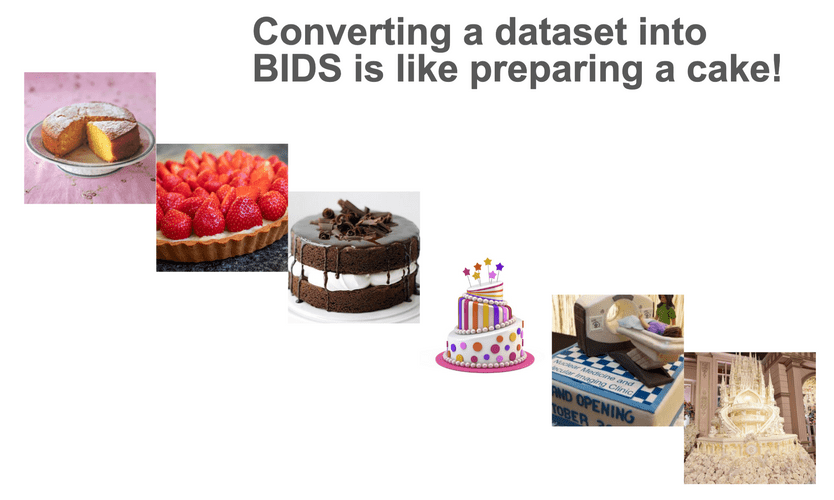

---
STEP 2 - Gather your cooking tools
---


Prerequisite for this Hand-On toolbox are [dcm2niix](https://github.com/rordenlab/dcm2niix) and [dcm2bids](https://unfmontreal.github.io/Dcm2Bids/).


First step is to install `dcm2niix` from the *rodenlab* repository on github. For this Hands-On workshop we are going to download the latest release with the `curl` command and install it in this *Google Colaborative notebook*. If you want to test it in your local environment please refer to how to install dcm2niix for your platform [LINK](https://github.com/rordenlab/dcm2niix#install).

Second step is to install `dcm2bids` using pip. If you want to test it in you local environment please refer to the [setup tutorial](https://unfmontreal.github.io/Dcm2Bids/docs/2-tutorial/#setup) section on the `dcm2bids` page.

Google colab default language is python, however please note that it is possible to provide also shell command to it. Indeed, the command with `!` prefix are passed to the shell and run directly on the notebook environment. If you need a deeper walktrought on the shell features of google colab please have a look to this [YouTube video](https://www.youtube.com/watch?v=E54volo2B2s).

In [ ]:
!curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
!unzip -o dcm2niix_lnx.zip
!mv dcm2niix /bin
!pip install dcm2bids

# STEP 3 - Gather your ingredients


---
Get the sample dataset and organize the file for the conversion.

We provide a DICOM anonymized anatomical dataset to test the DICOM to BIDS conversion. The dataset comprise structural `T1w` MPRAGE sequences taken in three different sessions for two subjects *001* and *002*. 

We use `wget` to dowload the dataset shared within a dropbox folder. 

You can get the dataset [HERE](https://www.dropbox.com/s/nxzgxdwhwfzfmvg/ExampleDataset.zip) to further try the conversion on your local machine.

We create a /content/DICOM folder in the google colab notebook disk and we unzip the downloaded dateset to be further processed.

In [ ]:
!wget https://www.dropbox.com/s/1wvaed0fc8rqvsh/ExampleDataset.zip
!mkdir DICOM
!unzip -d /content/DICOM -o /content/ExampleDataset.zip 

# STEP 4 - Bake the cake

---
To explore how the dataset has been collected and select the DICOM that can be converted to BIDS format we can firstly use `dcm2bids_helper` that will do the conversion with `dcm2niix` and will provide an example NIFTI and json pair to investigate wheter the json has the `REQUIRED`, `RECOMMENDED` and `OPTIONAL` fields we need.






In [ ]:
!dcm2bids_helper -d /content/DICOM/ExampleDataset/001 -o /content/NIFTI
!cat /content/NIFTI/tmp_dcm2bids/helper/002_001_T1_mprage_20161103185731.json

Now that the DICOM files have been extracted we need to write a configuration file for `dcm2bids`. To write a file in the google colab folder you can use the `%%writefile` command on top of the cell you want to write to the file. 

The configuration file contains important information on how to match DICOM files in the original dataset with BIDS MRI modality. It is formatted as a `json` file and there are mandatory fields like 


>`dataType` that indicates the type of image the DICOM contains (`anat`, `func`, `dwi`, `perfusion`, etc.)

>`modalityLabel` that indicates, in the case of anatomy imaging data, the suffix and hence the contast of the sequence acquired (`T1w`, `T2w`, `PDw`, `T2starw`, etc.)


You can find more information on the Anatomy Imaging Data BIDS specification [HERE](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/01-magnetic-resonance-imaging-data.html#anatomy-imaging-data).

In this case we know that the dataset is made of anatomical images acquired with the MPRAGE sequence, hence we need to find a way to match the NIFTI converted from dcm2niix with the datatype, the modality we need. To do so, we need to introduce the criteria field the will look in the filename of the converted NIFTI file for a pattern, in this case we will use the wildcard character `*` and the pattern `T1_mprage` to perform the match.

The criteria field will be applied to the `SeriesDescription` field of the json and will link the correspondent NIFTI file. 


In [ ]:
%%writefile dcm2bids_config.json
{
    "descriptions": [
        {
        "dataType": "anat",
        "modalityLabel" : "T1w",
        "criteria": {
            "SeriesDescription": "*T1_mprage*"
            }
        }
    ]
}

## Use dcm2bids to perform an automatic conversion to BIDS compatible dataset directly from DICOM

Here we use `dcm2bids` separately for each subject of the dataset, with extra parameters:

`dcm2bids` `-d` DICOM_Folder `-p` ID_SUB `-c` dcm2bids_configuration.json `-o` output_folder

In [ ]:
!rm -rf /content/BIDS_dataset 
!rm -rf /content/NIFTI
!rm -rf /content/tmp_dcm2bids
!rm -rf /content/sub*

!dcm2bids  -d /content/DICOM/ExampleDataset/001/Ses1 -p 001 -s 001 -c /content/dcm2bids_config.json -o /content/BIDS_dataset
!dcm2bids  -d /content/DICOM/ExampleDataset/001/Ses2 -p 001 -s 002 -c /content/dcm2bids_config.json -o /content/BIDS_dataset
!dcm2bids  -d /content/DICOM/ExampleDataset/001/Ses3 -p 001 -s 003 -c /content/dcm2bids_config.json -o /content/BIDS_dataset
!dcm2bids  -d /content/DICOM/ExampleDataset/002/Ses1 -p 002 -s 001 -c /content/dcm2bids_config.json -o /content/BIDS_dataset
!dcm2bids  -d /content/DICOM/ExampleDataset/002/Ses2 -p 002 -s 002 -c /content/dcm2bids_config.json -o /content/BIDS_dataset
!dcm2bids  -d /content/DICOM/ExampleDataset/002/Ses3 -p 002 -s 003 -c /content/dcm2bids_config.json -o /content/BIDS_dataset


We can now have a look to an exaple json sidecar that has been created by `dcm2bids`.

In [ ]:
!cat /content/BIDS_dataset/sub-001/ses-001/anat/sub-001_ses-001_T1w.json

# STEP 5 - Try your cake

The BIDS Validator is a Javascript app written in Node.js that can be used to validate a BIDS dataset, in other words it tells you whether your dataset is complyant with the BIDS specifications. It is a web based app and in princple it is not necessary to install it locally but you can use directly this [LINK](http://bids-standard.github.io/bids-validator/).

We will try now to validate the dcm2bids automated created dataset to see if it has done a good job.

First of all, we need to download the dataset, to facilitate this operation, we can zip the `BIDS_dataset` folder, download it, inflated it and feed the whole directory to the validator.

In [ ]:
!rm -rf /content/BIDS_dataset/tmp_dcm2bids
!cd /content; zip -r /content/BIDS_dataset.zip ./BIDS_dataset;



###1.   Download the zipped dataset folder on your laptop

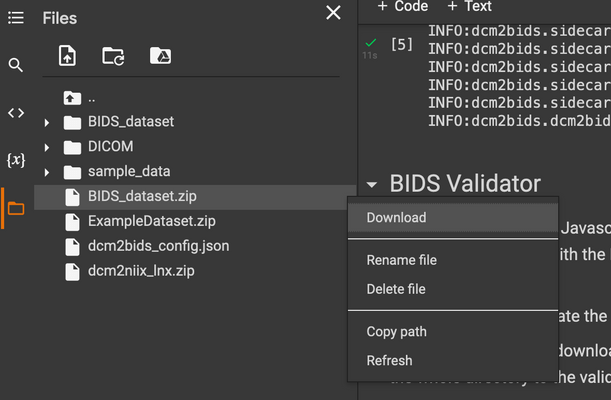

###2.   Inflate the zip locally
###3.   Upload the folder in the BIDS validator web based app.

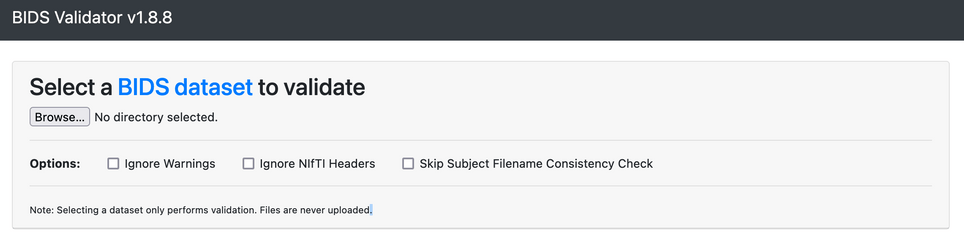



# STEP 6 - Decorate the cake

---
## Write Modality agnostic files 
 The BIDS dataset we created was missing of some mandatory files, hence we got both errors and warnings from the BIDS validator.
 
 Modality agnostic files are required to be included in each BIDS dataset to assure that the dataset can be shared and re-used respecting the idea of the open science manifesto and to let scientist to reproduce the work done by other goups in the most transparent way. (more information [HERE](https://bids-specification.readthedocs.io/en/stable/03-modality-agnostic-files.html))

` dataset_description.json` is a JSON file describing the dataset. Every dataset MUST include this file with the following fields: 

<br>
<table align="left"> 
  <tr>
    <th>Key name</th>
    <th>Requirement level</th>
    <th>Data type</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>Name</td>
    <td>REQUIRED</td>
    <td>string</td>
    <td>Name of the dataset.</td>
  </tr>
  <tr>
    <td>BIDSVersion</td>
    <td>REQUIRED</td>
    <td>string</td>
    <td>The version of the BIDS standard that was used.</td>
</table>
<br>
<br>
<br>
<br>

`participants.tsv` include informations of each participants and can be further described by an optional file called `participants.json`


`README` In addition a free form text file (README) describing the dataset in more details SHOULD be provided. The README file MUST be either in ASCII or UTF-8 encoding.



In [ ]:
%%writefile BIDS_dataset/participants.tsv
participant_id
sub-001 
sub-002

In [ ]:
%%writefile BIDS_dataset/dataset_description.json
{
  "Name": "Bids Workshop",
  "BIDSVersion":  "1.6.0",
  "Authors": [
    "Marco Castellaro",
    "Patricia Clement"
  ]
}

In [ ]:
%%writefile BIDS_dataset/README
This dataset is release for use in BIDS workshop. 

# STEP 7 - Repeat step 5 - Try your cake again

We can now repeat the zip and download operation and the validation procedure that will produce no errors or warnings.

In [ ]:
!rm -rf /content/BIDS_dataset/tmp_dcm2bids
!cd /content; zip -r /content/BIDS_dataset.zip ./BIDS_dataset;